In [2]:
# import packages
import sys, os 
import pandas as pd
import numpy as np
np.seterr(divide='ignore',invalid='ignore')
import matplotlib.pyplot as plt
import json
import trodes2SS
import sungod_util

from spykshrk.realtime.datatypes import Datatypes
import loren_frank_data_processing as lfdp
from loren_frank_data_processing import Animal
import scipy as sp
from spykshrk.franklab.data_containers import RippleTimes, pos_col_format#FlatLinearPosition, SpikeFeatures, Posteriors, \
         #EncodeSettings, pos_col_format, SpikeObservation, RippleTimes, DayEpochEvent, DayEpochTimeSeries

%load_ext autoreload
%autoreload 2

idx = pd.IndexSlice
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 120)

In [ ]:
# cell to start up holoviews
import holoviews as hv

import scipy as sp

hv.extension('bokeh')

In [ ]:
# cell to test and make sure holoviews and bokeh are working
coords = np.random.rand(50,2)
points = hv.Points(coords)

points.opts(color='k', marker='+', size=10)

In [48]:
# cell to read real-time hdf5 file

#12-17, bill run session 3
#hdf_file = '/stelmo/mcoulter/spykshrk_output/bill/20191217_bill_05_r3_westerlies_streaming.rec_merged.h5'

#12-22, bill run session 
#hdf_file = '/stelmo/mcoulter/bill/raw/20191222/20191222_bill_02_r1_westerlies_streaming.rec_merged.h5'

# 2-3 with no delay, no_spike loop fix
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_3_no_spike_fix.rec_merged.h5'

# 2-4 1 bin delay, no_spike loop fix sorta
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_4_delay_no_spike.rec_merged.h5'

# 2-5 1 bin delay, no_spike loop fix, whole session
#hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_5_post_lockout.rec_merged.h5'

# 2-6 1 bin delay, whole session, encode all spikes
hdf_file = '/stelmo/mcoulter/spykshrk_output_westerlies/remy_decoder_19tet_2_6_encode_all_time.rec_merged.h5'


store = pd.HDFStore(hdf_file, mode='r')

In [4]:
# cell to fill in dataframes with realtime data
encoder_data = store['rec_3']
decoder_data = store['rec_4']
decoder_missed_spikes = store['rec_5']
ripple_data = store['rec_1']
#stim_state = store['rec_10']
stim_lockout = store['rec_11']
stim_message = store['rec_12']
timing = store['rec_100']

In [13]:
# 2-4 with decoder delay
encoder_data1 = store['rec_3']
decoder_data1 = store['rec_4']
decoder_missed_spikes1 = store['rec_5']
ripple_data1 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout1 = store['rec_11']
stim_message1 = store['rec_12']
timing1 = store['rec_100']

In [38]:
# 2-5 with decoder delay, whole session
encoder_data2 = store['rec_3']
decoder_data2 = store['rec_4']
decoder_missed_spikes2 = store['rec_5']
ripple_data2 = store['rec_1']
#stim_state = store['rec_10']
stim_lockout2 = store['rec_11']
stim_message2 = store['rec_12']
timing2 = store['rec_100']

In [50]:
# 2-5 with decoder delay, whole session
encoder_data3 = store['rec_3']
decoder_data3 = store['rec_4']
decoder_missed_spikes3 = store['rec_5']
likelihood_data3 = store['rec_6']
occupancy_data3 = store['rec_7']
ripple_data3 = store['rec_1']
#stim_state = store['rec_10']
#stim_lockout3 = store['rec_11']
#stim_message3 = store['rec_12']
timing3 = store['rec_100']

In [19]:
# Bill offline decode
file_path = '/stelmo/mcoulter/bill/filterframework/bill_7_2_shuffle_0_tets_only_posteriors_functionalized_mvt.h5'
hdf_base = '/analysis'
hdf_grps = 'decode/clusterless/offline/posterior'
hdf_label = 'sungod_trans_mat'

with pd.HDFStore(file_path, 'r') as store:
    main_path = os.path.join(hdf_base, hdf_grps, hdf_label)
    posteriors2 = store[main_path]

In [60]:
#remy 20, 2 offline decode
file_path = '/stelmo/mcoulter/oct_2019_decoding/remy_20_2_shuffle_0_posteriors_functionalized_150_decode_whole.h5'
hdf_base = '/analysis'
hdf_grps = 'decode/clusterless/offline/posterior'
hdf_label = 'sungod_trans_mat'

with pd.HDFStore(file_path, 'r') as store:
    main_path = os.path.join(hdf_base, hdf_grps, hdf_label)
    posteriors2 = store[main_path]

In [62]:
# get linear position for offline

#### Define parameters
rat_name = 'remy'
day =  20     #previously:{'remy':[20], 'gus':[28], 'bernard':[23], 'fievel':[19]}
epoch = 2   # previously:{'remy':[4], 'gus':[2], 'bernard':[4], 'fievel':[2]} 

# define data source filepaths
path_base = '/stelmo/mcoulter/'
#path_base = '/mnt/vortex/mcoulter/'
#raw_directory = path_base + rat_name + '/filterframework/'
raw_directory = path_base + 'raw_data/' + rat_name + '/'
linearization_path = path_base + 'maze_info/'
#linearization_path = raw_directory
day_ep = str(day) + '_' + str(epoch)

#tetlist = None
tetlist = [4]
tetrodes= tetlist

pos_bin_size = 5
velocity_thresh_for_enc_dec = 8
velocity_buffer = 0

shift_amt_for_shuffle = 0

use_enc_as_dec = 1   #if you want to use the encoding marks as the decoding marks

discrete_tm_val=.99   # for classifier

# IMPORT and process data

#initialize data importer
datasrc = trodes2SS.TrodesImport(raw_directory, rat_name, [day], 
                       [epoch], tetrodes)

# Import trials
trials = datasrc.import_trials()

# Import raw position
linear_pos_raw = datasrc.import_pos(xy='x')   # this is basically just to pull in speed, will be replaced with linearized below
#posY = datasrc.import_pos(xy='y')          #  OPTIONAL; useful for 2d visualization

# if linearization exists, load it. if not, run the linearization.
lin_output1 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_distance.npy'
lin_output2 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_track_segments.npy'
linear_pos_raw['linpos_flat'] = np.load(lin_output1)   #replace x pos with linerized 
track_segment_ids = np.load(lin_output2)
print('Linearization found. Loading it')

# generate boundary definitions of each segment
arm_coords, _ = sungod_util.define_segment_coordinates(linear_pos_raw, track_segment_ids)  # optional addition output of all occupied positions (not just bounds)

#bin linear position 
binned_linear_pos, binned_arm_coords, pos_bins = sungod_util.bin_position_data(linear_pos_raw, arm_coords, pos_bin_size)


Linearization found. Loading it
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  64.
  69.  74.  79.  84.  89.  94.  99. 104. 109. 114. 119. 124. 129. 134.
 139. 144. 147. 152. 157. 162. 167. 172. 177. 182. 187. 192. 197. 202.
 207. 212. 217. 222. 227. 232. 237. 242. 247. 252. 257. 262. 267. 272.
 277. 282. 287. 292. 297. 302. 307. 312. 317. 319. 324. 329. 334. 339.
 344. 349. 354. 359. 364. 369. 374. 379. 384. 389. 394. 399. 403. 408.
 413. 418. 423. 428. 433. 438. 443. 448. 453. 458. 463. 468. 473. 478.
 483. 485. 490. 495. 500. 505. 510. 515. 520. 525. 530. 535. 540. 545.
 550. 555. 560. 565. 568. 573. 578. 583. 588. 593. 598. 603. 608. 613.
 618. 623. 628. 633. 638. 643. 648. 649. 654. 659. 664. 669. 674. 679.
 684. 689. 694. 699. 704. 709. 714.]
[[  0   8]
 [ 13  25]
 [ 30  42]
 [ 47  59]
 [ 65  77]
 [ 82  94]
 [ 99 111]
 [116 128]
 [133 145]]


In [63]:
#calculate max for offline posteriors
post_to_merge = posteriors2.copy()

#calculate posterior max
post_to_merge1 = post_to_merge.drop(['num_spikes','dec_bin','ripple_grp'], axis=1)
post_to_merge1.fillna(0,inplace=True)
post_to_merge1['posterior_max'] = post_to_merge1.idxmax(axis=1)
post_to_merge1['posterior_max'] = post_to_merge1['posterior_max'].str.replace('x','')
post_to_merge1['posterior_max'] = post_to_merge1['posterior_max'].astype(int)

#post_to_merge.reset_index(level=['timestamp'],inplace=True)
post_to_merge1.reset_index(inplace=True)
post_to_merge1['timestamp1']=post_to_merge1['timestamp']

#calculate posterior max

#post_to_merge.set_index('timestamp', append=True, inplace=True)
#post_to_merge.set_index('dat','epoch','timestamp', 'time',append=True, inplace=True)
#post_to_merge1 = post_to_merge.reorder_levels(['day', 'epoch', 'timestamp', 'time'])
post_to_merge1

pos_vel = binned_linear_pos.copy()
pos_vel1 = pos_vel.reset_index()
pos_vel1['timestamp1'] = pos_vel1['timestamp']
pos_vel2 = pos_vel1.drop(['day','epoch','time','timestamp'], axis=1)

posterior_with_pos_vel = pd.merge_asof(post_to_merge1,pos_vel2,on='timestamp1',direction='nearest')
posterior_with_pos_vel['error_cm'] = abs(posterior_with_pos_vel['posterior_max']-posterior_with_pos_vel['linpos_flat'])*5
posterior_with_pos_vel

post_error_plot_off = posterior_with_pos_vel.copy()
#post_error_plot_off = post_error_plot[100:821700]
#post_error_plot_off = post_error_plot_off[post_error_plot_off['linvel_flat']>8]
post_error_plot_off.shape

(821703, 155)

In [8]:
posteriors2.shape

(1509115, 87)

In [ ]:
# generate posterior error dataframe for real-time data
decoder_data
post_error = decoder_data.copy()

#post_error.drop(columns=['rec_ind', 'timestamp','real_pos_time','real_pos','spike_count'],inplace=True)
post_error.drop(columns=['rec_ind','bin_timestamp','wall_time','velocity','real_pos',
                         'raw_x','raw_y','smooth_x','smooth_y','next_bin',
                         'spike_count','ripple','ripple_number','ripple_length',
                         'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                         'arm6','arm7','arm8'], inplace=True)

post_error.fillna(0,inplace=True)
post_error['max_position'] = post_error.idxmax(axis=1)
post_error['max_position'] = post_error['max_position'].str.replace('x','')
post_error['max_position'] = post_error['max_position'].astype(int)

#now need to add back columns 'timestamp','real_pos_time','real_pos'
# try adding back spike_count too
post_error['timestamp'] = decoder_data['bin_timestamp']
post_error['real_vel'] = decoder_data['velocity']
post_error['real_pos'] = decoder_data['real_pos']
post_error['spike_count'] = decoder_data['spike_count']
#this is the error column in centimeters
post_error['error_cm'] = abs(post_error['max_position']-decoder_data['real_pos'])*5

post_error

In [ ]:
# generate posterior error dataframe for real-time data
post_error1 = decoder_data1.copy()

post_error1.drop(columns=['rec_ind','bin_timestamp','wall_time','velocity','real_pos',
                         'raw_x','raw_y','smooth_x','smooth_y','next_bin',
                         'spike_count','ripple','ripple_number','ripple_length',
                         'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                         'arm6','arm7','arm8'], inplace=True)
post_error1.fillna(0,inplace=True)
post_error1['max_position'] = post_error1.idxmax(axis=1)
post_error1['max_position'] = post_error1['max_position'].str.replace('x','')
post_error1['max_position'] = post_error1['max_position'].astype(int)

#now need to add back columns 'timestamp','real_pos_time','real_pos'
# try adding back spike_count too
post_error1['timestamp'] = decoder_data1['bin_timestamp']
post_error1['real_vel'] = decoder_data1['velocity']
post_error1['real_pos'] = decoder_data1['real_pos']
post_error1['spike_count'] = decoder_data1['spike_count']
#this is the error column in centimeters
post_error1['error_cm'] = abs(post_error1['max_position']-decoder_data1['real_pos'])*5

post_error1

In [ ]:
# generate posterior error dataframe for real-time data
post_error2 = decoder_data2.copy()

post_error2.drop(columns=['rec_ind','bin_timestamp','wall_time','velocity','real_pos',
                         'raw_x','raw_y','smooth_x','smooth_y','next_bin',
                         'spike_count','ripple','ripple_number','ripple_length',
                         'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                         'arm6','arm7','arm8'], inplace=True)
post_error2.fillna(0,inplace=True)
post_error2['max_position'] = post_error2.idxmax(axis=1)
post_error2['max_position'] = post_error2['max_position'].str.replace('x','')
post_error2['max_position'] = post_error2['max_position'].astype(int)

#now need to add back columns 'timestamp','real_pos_time','real_pos'
# try adding back spike_count too
post_error2['timestamp'] = decoder_data2['bin_timestamp']
post_error2['real_vel'] = decoder_data2['velocity']
post_error2['real_pos'] = decoder_data2['real_pos']
post_error2['spike_count'] = decoder_data2['spike_count']
#this is the error column in centimeters
post_error2['error_cm'] = abs(post_error2['max_position']-decoder_data2['real_pos'])*5

post_error2

In [55]:
# generate posterior error dataframe for real-time data
post_error3 = decoder_data3.copy()

post_error3.drop(columns=['rec_ind','bin_timestamp','wall_time','velocity','real_pos',
                         'raw_x','raw_y','smooth_x','smooth_y','next_bin',
                         'spike_count','ripple','ripple_number','ripple_length',
                         'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                         'arm6','arm7','arm8'], inplace=True)
post_error3.fillna(0,inplace=True)
post_error3['max_position'] = post_error3.idxmax(axis=1)
post_error3['max_position'] = post_error3['max_position'].str.replace('x','')
post_error3['max_position'] = post_error3['max_position'].astype(int)

#now need to add back columns 'timestamp','real_pos_time','real_pos'
# try adding back spike_count too
post_error3['timestamp'] = decoder_data3['bin_timestamp']
post_error3['real_vel'] = decoder_data3['velocity']
post_error3['real_pos'] = decoder_data3['real_pos']
post_error3['spike_count'] = decoder_data3['spike_count']
#this is the error column in centimeters
post_error3['error_cm'] = abs(post_error3['max_position']-decoder_data3['real_pos'])*5

post_error3
post_error_plot3 = post_error3.copy()
post_error_plot3 = post_error_plot3
#post_error_plot3 = post_error_plot3[post_error_plot3['real_vel']>8]
post_error_plot3.shape

(819874, 143)

In [ ]:
plt.hist(post_error['spike_count'].values,bins=np.arange(0,10),density=True)
post_error.shape

In [ ]:
# make version of encoder_data for plotting - to look at histogram of max position of observations
observ_error = encoder_data.copy()

observ_error.drop(columns=['rec_ind', 'timestamp','elec_grp_id','position'],inplace=True)
observ_error.fillna(0,inplace=True)
observ_error['max_position'] = observ_error.idxmax(axis=1)
observ_error['max_position'] = observ_error['max_position'].str.replace('x','')
observ_error['max_position'] = observ_error['max_position'].astype(int)

##now need to add back columns 'timestamp','real_pos_time','real_pos'
#post_error['timestamp'] = decoder_data['timestamp']
#post_error['real_vel'] = decoder_data['real_pos_time']
#post_error['real_pos'] = decoder_data['real_pos']
##this is the error column in centimeters
#post_error['error_cm'] = abs(post_error['max_position']-decoder_data['real_pos'])*5

observ_error

In [ ]:
#plt.plot(post_error['real_pos'].values[550000:580000])
#plt.plot(post_error['real_pos'].values[0:5800])
#plt.plot(post_error['real_vel'].values[0:5800])
post_error[500:580000]

In [10]:
#for plotting: without prob_no_spike, then only keep bins where real_vel > 8
#for plotting with shortened session: use time bins 500:580000
post_error_plot = post_error.copy()
#post_error_plot = post_error_plot[500:580000]
post_error_plot = post_error_plot[post_error_plot['real_vel']>8]
post_error_plot.shape

(212177, 143)

In [21]:
#for plotting: with prob_no_spike
# 2-4 1 bin delay
post_error_plot1 = post_error1.copy()
post_error_plot1 = post_error_plot1[0:431985]
post_error_plot1 = post_error_plot1[post_error_plot1['real_vel']>8]
post_error_plot1.shape

(212237, 143)

In [54]:
#for plotting: with prob_no_spike
# 2-5 1 bin delay whole session
post_error_plot2 = post_error2.copy()
post_error_plot2 = post_error_plot2
#post_error_plot2 = post_error_plot2[post_error_plot2['real_vel']>8]
post_error_plot2.shape

(784686, 143)

In [ ]:
#total range: [0,173500]
plt.figure(figsize=(15,5))
plt.scatter(post_error_plot['timestamp'].values[0:204000],post_error_plot['real_pos'].values[0:204000],s=10)
plt.scatter(post_error_plot['timestamp'].values[0:204000],post_error_plot['max_position'].values[0:204000],s=3,alpha=0.3)
#plt.scatter(post_error_plot['timestamp'].values[0:2000],post_error_plot['real_vel'].values[0:2000],s=5,alpha=0.3)

#plt.scatter(post_error_plot['timestamp'].values[100000:110000],post_error_plot['real_pos'].values[100000:110000],s=10)
#plt.scatter(post_error_plot['timestamp'].values[100000:110000],post_error_plot['max_position'].values[100000:110000],s=3,alpha=0.3)

#plt.scatter(post_error['timestamp'].values[0:680000],post_error['real_pos'].values[0:680000],s=10)
#plt.scatter(post_error['timestamp'].values[450000:460000],post_error['max_position'].values[450000:460000],s=3,alpha=0.3)
#plt.scatter(post_error['timestamp'].values[0:125000],post_error['spike_count'].values[123000:125000]*10,s=3,alpha=1)

#plt.ylim([-2,50])

In [ ]:
#realtime position and decoded position
plt.figure(figsize=(15,5))
plt.scatter(post_error_plot1['timestamp'].values[69000:73000],post_error_plot1['real_pos'].values[69000:73000],s=10)
plt.scatter(post_error_plot1['timestamp'].values[69000:73000],post_error_plot1['max_position'].values[69000:73000],s=3,alpha=0.3)
#

In [ ]:
# arm 6 shadow time 116141100 - 120145200
post_error_plot1[69000:73000]

In [19]:
decoder_data.shape

(431985, 161)

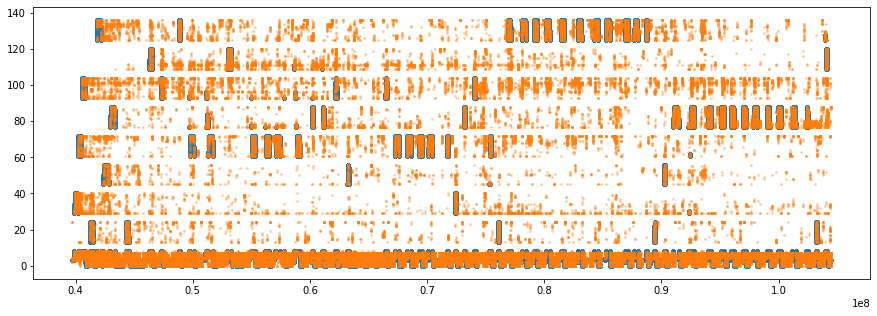

In [11]:
#2-3 no decoder delay
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot['timestamp'].values,post_error_plot['real_pos'].values,s=10)
plt.scatter(post_error_plot['timestamp'].values,post_error_plot['max_position'].values,s=3,alpha=0.3)


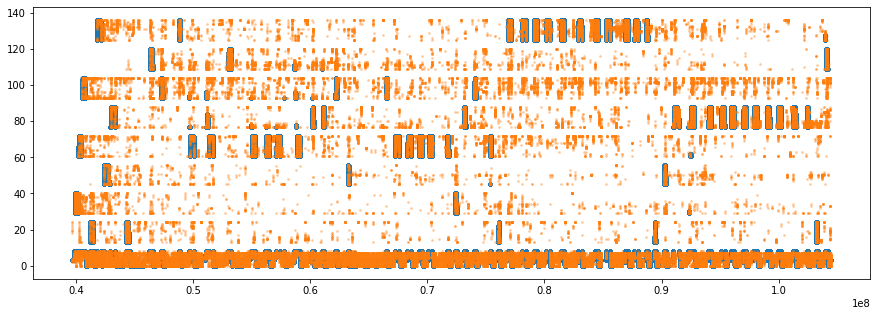

In [22]:
#2-4 1 bin decoder delay
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot1['timestamp'].values,post_error_plot1['real_pos'].values,s=10)
plt.scatter(post_error_plot1['timestamp'].values,post_error_plot1['max_position'].values,s=3,alpha=0.3)


<IPython.core.display.Javascript object>


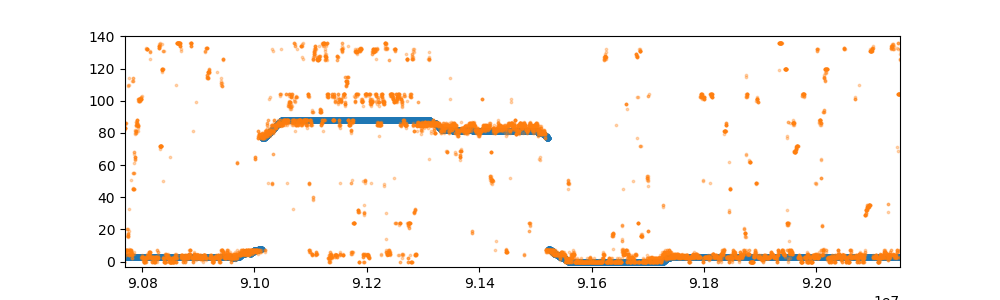

In [58]:
%matplotlib notebook
#2-5 1 bin decoder delay, whole session
plt.figure(figsize=(10,3))

plt.scatter(post_error_plot2['timestamp'].values,post_error_plot2['real_pos'].values,s=10)
plt.scatter(post_error_plot2['timestamp'].values,post_error_plot2['max_position'].values,s=3,alpha=0.3)


<IPython.core.display.Javascript object>


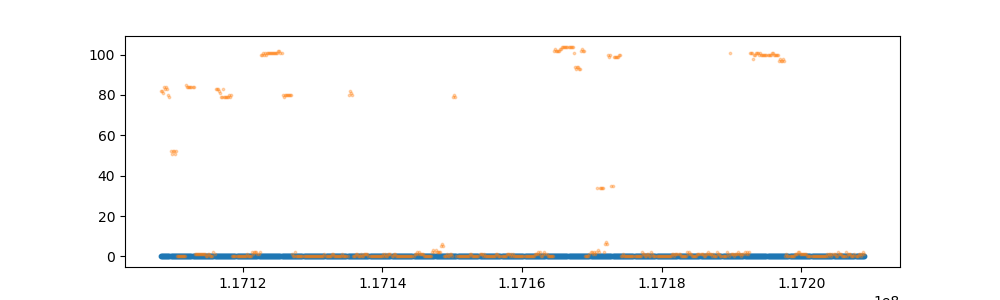

In [92]:
#2-6 1 bin decoder delay, whole session, encode all spikes
plt.figure(figsize=(10,3))

post_error_plot_subset = post_error_plot3[(post_error_plot3['timestamp']>117108156) & 
                                          (post_error_plot3['timestamp']<117209059)]

plt.scatter(post_error_plot_subset['timestamp'].values,post_error_plot_subset['real_pos'].values,s=10)
plt.scatter(post_error_plot_subset['timestamp'].values,post_error_plot_subset['max_position'].values,s=3,alpha=0.3)


<IPython.core.display.Javascript object>


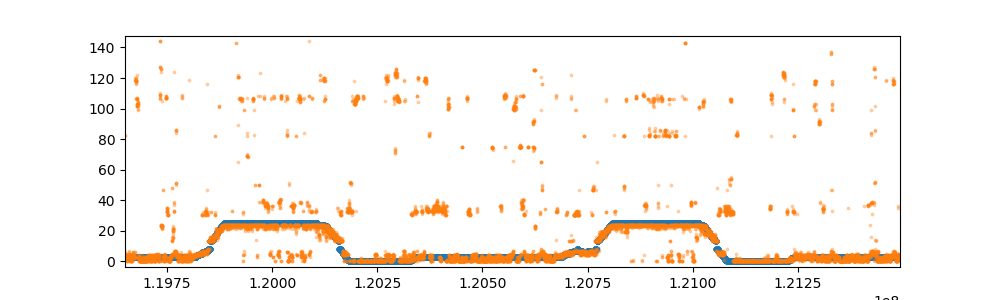

In [66]:
#offline position and decoded position - remy
plt.figure(figsize=(10,3))

plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['linpos_flat'].values,s=10)
plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['posterior_max'].values,s=3,alpha=0.3)


<IPython.core.display.Javascript object>


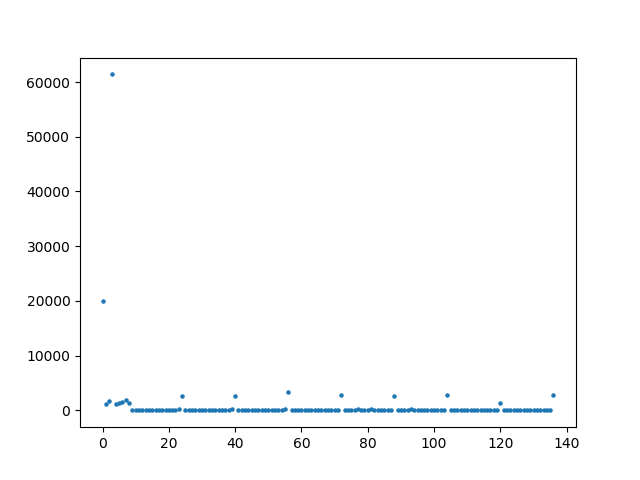

In [102]:
# real-time occupancy - remy 20, 2
# close to final bin
occupancy_data3
occupancy_to_plot = occupancy_data3[(occupancy_data3['bin_timestamp']>=162598156) & 
                                    (occupancy_data3['bin_timestamp']<162599059)]
occupancy_to_plot.iloc[:,3:140]
#occupancy_to_plot.shape
plt.scatter(np.arange(0,137),occupancy_to_plot.iloc[:,3:140].values,s=5)

In [98]:
# real-time occupancy - remy 20, 2
# right after runs down arm 6
occupancy_data3
occupancy_to_plot = occupancy_data3[(occupancy_data3['bin_timestamp']>=117108574) & 
                                    (occupancy_data3['bin_timestamp']<117109468)]
#occupancy_to_plot.iloc[:,3:140]
occupancy_to_plot.iloc[:,3:140].values
#plt.scatter(np.arange(0,137),occupancy_to_plot.iloc[:,3:140].values,s=5)

array([[1.2804e+04, 7.8200e+02, 1.0570e+03, 3.8642e+04, 8.5800e+02,
        8.8400e+02, 1.0410e+03, 1.2280e+03, 9.3900e+02, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 4.2000e+01, 5.4000e+01,
        3.5000e+01, 4.9000e+01, 3.1000e+01, 3.6000e+01, 2.7000e+01,
        2.6000e+01, 3.6000e+01, 3.5000e+01, 1.0700e+02, 4.5700e+02,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.5000e+01,
        2.3000e+01, 1.7000e+01, 1.5000e+01, 1.7000e+01, 1.7000e+01,
        1.7000e+01, 1.5000e+01, 1.9000e+01, 2.1000e+01, 4.4000e+01,
        3.4900e+02, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        3.3000e+01, 8.6000e+01, 4.3000e+01, 1.6000e+01, 1.7000e+01,
        1.4000e+01, 1.6000e+01, 1.5000e+01, 1.5000e+01, 2.4000e+01,
        4.6000e+01, 4.3700e+02, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0900e+02, 8.4000e+01, 7.4000e+01, 7.3000e+01,
        7.5000e+01, 6.2000e+01, 6.0000e+01, 6.3000e+01, 7.2000e+01,
        9.3000e+01, 1.6100e+02, 2.7950e+03, 1.00

<IPython.core.display.Javascript object>


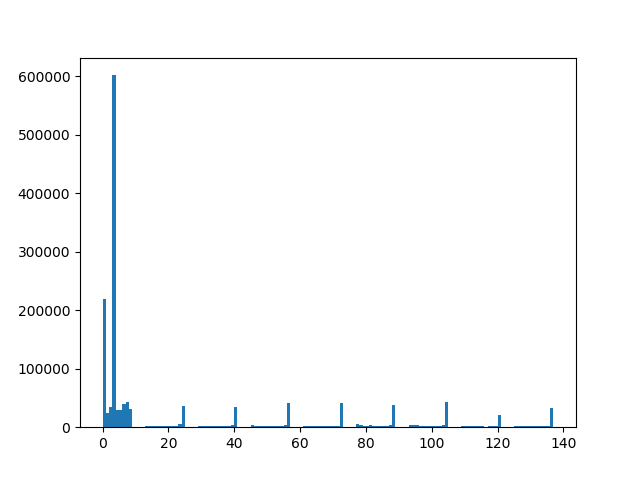

(array([219605.,  23504.,  34489., 601444.,  29705.,  28727.,  38947.,
         43678.,  31019.,      0.,      0.,      0.,      0.,   2389.,
          2492.,   2777.,   2576.,   2551.,   2153.,   1835.,   1900.,
          1902.,   2238.,   5095.,  36164.,      0.,      0.,      0.,
             0.,   2305.,   2164.,   1957.,   1929.,   1776.,   1835.,
          1690.,   1545.,   1618.,   1868.,   4186.,  34058.,      0.,
             0.,      0.,      0.,   3083.,   2732.,   2239.,   2536.,
          1871.,   1489.,   1452.,   1559.,   1912.,   1926.,   3900.,
         41406.,      0.,      0.,      0.,      0.,   2246.,   1705.,
          1524.,   1412.,   1559.,   1208.,   1298.,   1202.,   1231.,
          1687.,   2613.,  41634.,      0.,      0.,      0.,      0.,
          4754.,   3388.,   2708.,   2481.,   3884.,   2885.,   2090.,
          2165.,   1663.,   2006.,   3195.,  37326.,      0.,      0.,
             0.,      0.,   4486.,   3734.,   3412.,   2775.,   2465.,
      

In [105]:
plt.hist(encoder_data3['position'].values,bins=np.arange(0,138))


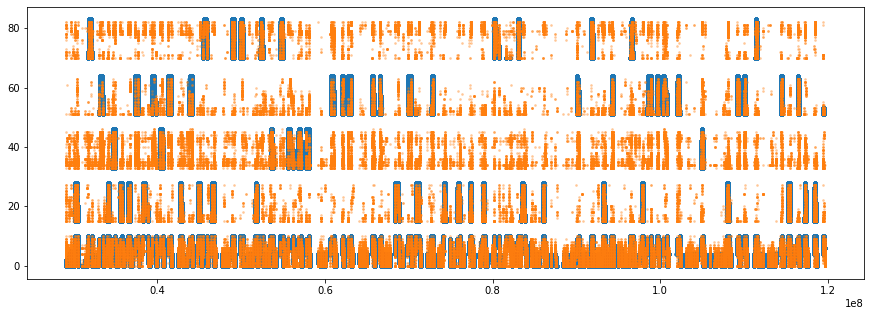

In [9]:
#offline position and decoded position - bill
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['linpos_flat'].values,s=10)
plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['posterior_max'].values,s=3,alpha=0.3)


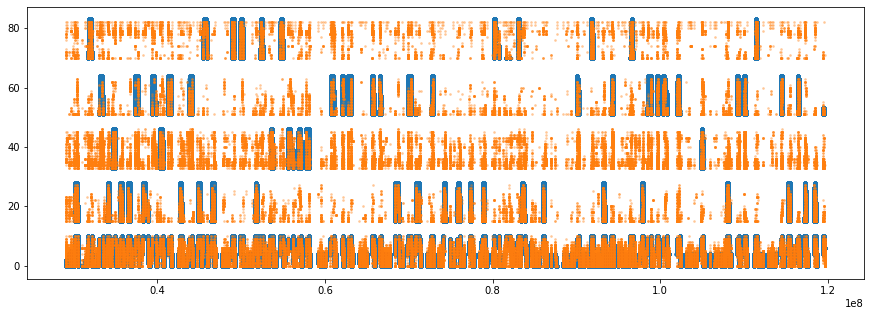

In [21]:
#offline position and decoded position
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['linpos_flat'].values,s=10)
plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['posterior_max'].values,s=3,alpha=0.3)


In [ ]:
plt.figure(figsize=(15,5))

plt.hist(post_error_plot_off['linpos_flat'].values,bins=np.arange(0,147),alpha=0.5)
#plt.hist(post_error_plot1['real_pos'].values[0:110000],bins=np.arange(0,147),alpha=0.5)
post_error_plot1.shape


In [ ]:
plt.figure(figsize=(15,5))

#plt.hist(post_error_plot_off['linpos_flat'].values,bins=np.arange(0,147),alpha=0.5)
plt.hist(post_error_plot1['real_pos'].values[0:110000],bins=np.arange(0,147),alpha=0.5)
post_error_plot1.shape

In [ ]:
plt.figure(figsize=(15,5))

plt.hist(encoder_data_vel[encoder_data_vel['vel']>8]['position'].values,bins=np.arange(0,137))
encoder_data.shape
#plt.ylim([0,100000])

In [ ]:
plt.figure(figsize=(15,5))

plt.hist(encoder_data['position'].values,bins=np.arange(0,137))
encoder_data.shape
plt.ylim([0,100000])

In [ ]:
# we should plot occupancy normalized firing rate for each position bin like we did for offline
timestamp_vel = decoder_data[['timestamp']]
timestamp_vel['vel'] = decoder_data['real_pos_time']
timestamp_vel

encoder_data_vel = pd.merge_asof(encoder_data,timestamp_vel,on='timestamp',direction='nearest')
encoder_data_vel

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(post_error1['timestamp'].values[450000:680000],post_error1['real_pos'].values[450000:680000],s=10)
plt.scatter(post_error1['timestamp'].values[450000:680000],post_error1['real_vel'].values[450000:680000],s=10)
#plt.scatter(post_error1['timestamp'].values[450000:460000],post_error1['max_position'].values[450000:460000],s=3,alpha=0.3)


In [ ]:
plt.figure(figsize=(15,5))
plt.hist(post_error_plot['real_pos'].values[0:173500],bins=np.arange(0,137))
plt.hist(post_error_plot['max_position'].values[0:173500],bins=np.arange(0,137),alpha=0.6)
post_error_plot.shape

In [ ]:
#histogram of observations - each spike decoded
plt.hist(observ_error['max_position'].values,bins=np.arange(0,137))
observ_error.shape
plt.xlim([0,50])
plt.ylim([0,30000])

In [ ]:
#okay so occuapncy in spykshrk matches position histogram from decoding_data
occupancy = np.array([5.188e+03,869,719,838,4162,1592,1708,1865,33,1,1,1,111,116,93,107,82,86,69,74,88,103,235,795,1,1,1,1,
 73,71,61,52,60,51,51,50,63,75,157,517,1,1,1,1,34,36,62,33,17,18,16,16,17,23,43,135,
 1,1,1,1,129,98,82,77,83,69,63,63,75,91,145,490,1,1,1,1,276,188,137,109,104,119,100,
 93,82,109,152,578,1,1,1,1,208,139,136,112,88,85,78,80,89,102,149,548,
 1,1,1,1,58,60,45,36,29,29,26,21,28,45,60,146,1,1,1,1,93,125,100,112,86,76,76,75,82,100,170,4.260e+02])

plt.scatter(np.arange(0,len(occupancy)),occupancy)
plt.xlim([-1,50])

In [23]:
# if you want to calculate offline error set post_error_plot to post_error_plot_off
post_error_plot = post_error_plot_off

Text(0.5, 1.0, 'Decoding error during movement time for real-time decoder - median = 15 cm')

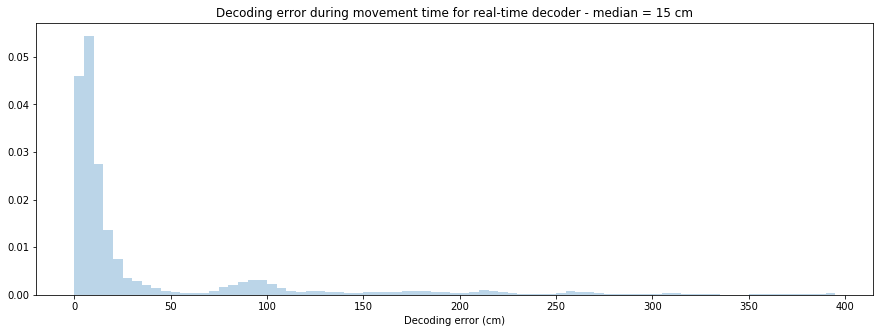

In [12]:
plt.figure(figsize=(15,5))
#plt.hist(post_error_plot['error_cm'].values[400:208682],bins=np.arange(0,700,5),density=True)
#plt.hist(post_error_plot['error_cm'].values[400:50000],bins=np.arange(0,700,5),density=True)
#plt.hist(post_error_plot['error_cm'].values[50000:100000],bins=np.arange(0,700,5),density=True, alpha=0.3)
#plt.hist(post_error_plot['error_cm'].values[100000:150000],bins=np.arange(0,700,5),density=True, alpha=0.3)
#plt.hist(post_error_plot['error_cm'].values[150000:208000],bins=np.arange(0,700,5),density=True, alpha=0.3)
# whole session
plt.hist(post_error_plot['error_cm'].values,bins=np.arange(0,400,5),density=True, alpha=0.3)

post_error_plot.shape

plt.xlabel('Decoding error (cm)')
plt.title('Decoding error during movement time for real-time decoder - median = 15 cm')

In [ ]:
# error in arms vs box
np.median(post_error_plot['error_cm'].values[400:208682])
np.median(post_error_plot['error_cm'].values[100000:208682])
print(np.median(post_error_plot[post_error_plot['real_pos']<10]['error_cm'].values[300:60000]))
print(np.median(post_error_plot[post_error_plot['real_pos']<10]['error_cm'].values[60000:124000]))
print(np.median(post_error_plot[post_error_plot['real_pos']>10]['error_cm'].values[0:41000]))
print(np.median(post_error_plot[post_error_plot['real_pos']>10]['error_cm'].values[41000:83000]))
#post_error_plot[post_error_plot['real_pos']>10]

In [14]:
post_error_plot

,day,epoch,timestamp,time,x00,x01,x02,x03,x04,x05,...,x79,x80,x81,x82,x83,posterior_max,timestamp1,linpos_flat,linvel_flat,error_cm
1,7,2,29093160,969.772,0.014905,0.015016,0.015025,0.015027,0.015088,0.015074,...,1.499129e-02,0.015073,1.498189e-02,1.506167e-02,1.021137e-02,34,29093160,0,8.452402,170
2,7,2,29093220,969.774,0.015125,0.015278,0.015328,0.015355,0.015434,0.015396,...,1.529833e-02,0.015370,1.530126e-02,1.373602e-02,8.217048e-03,34,29093220,0,8.452402,170
3,7,2,29093280,969.776,0.015330,0.015512,0.015599,0.015655,0.015741,0.015685,...,1.555017e-02,0.015652,1.503220e-02,1.269412e-02,6.982614e-03,34,29093280,0,8.452402,170
4,7,2,29093340,969.778,0.021432,0.065762,0.116562,0.105678,0.041884,0.014331,...,3.447937e-04,0.006992,1.085515e-02,1.312118e-10,9.532054e-11,2,29093340,0,8.452402,10
5,7,2,29093400,969.780,0.036090,0.068112,0.096290,0.088331,0.054399,0.025128,...,2.545205e-03,0.006196,6.043845e-03,3.734910e-03,6.809845e-05,2,29093400,0,8.452402,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509110,7,2,119639700,3987.990,0.327722,0.274470,0.189490,0.107095,0.050062,0.018682,...,4.585665e-04,0.000433,3.957534e-04,3.354174e-04,1.926007e-04,0,119639700,6,47.111600,30
1509111,7,2,119639760,3987.992,0.339957,0.268848,0.163955,0.104402,0.063127,0.025675,...,5.767868e-04,0.000546,5.427412e-04,4.221755e-04,1.972209e-08,0,119639760,6,47.111600,30
1509112,7,2,119639820,3987.994,0.307196,0.262590,0.162784,0.122967,0.067710,0.029863,...,6.095349e-04,0.000613,5.434749e-04,3.681809e-04,2.639022e-08,0,119639820,6,47.111600,30
1509113,7,2,119639880,3987.996,0.288859,0.243104,0.182100,0.117438,0.073608,0.037266,...,7.317604e-04,0.000688,6.038254e-04,4.031651e-04,1.507415e-04,0,119639880,6,47.111600,30


In [15]:
print(np.median(post_error_plot[post_error_plot['linpos_flat']<11]['error_cm'].values))
print(np.median(post_error_plot[post_error_plot['linpos_flat']>11]['error_cm'].values))

5.0
15.0


In [ ]:
post_error_plot = post_error_plot[0:161000]

In [36]:
# remote error
#arm_coords_rt = [[0,7],[12,23],[28,39],[44,55],[60,71],[76,87],[92,103],[108,119],[124,135]]
# new arm_coords 2-2020: [[0,8],[13,24],[29,40],[45,56],[61,72],[77,88],[93,104],[109,120],[125,136]]
box = post_error_plot[(post_error_plot['real_pos']>=0) & (post_error_plot['real_pos']<=8)]
arm1 = post_error_plot[(post_error_plot['real_pos']>=13) & (post_error_plot['real_pos']<=24)]
arm2 = post_error_plot[(post_error_plot['real_pos']>=29) & (post_error_plot['real_pos']<=40)]
arm3 = post_error_plot[(post_error_plot['real_pos']>=45) & (post_error_plot['real_pos']<=56)]
arm4 = post_error_plot[(post_error_plot['real_pos']>=61) & (post_error_plot['real_pos']<=72)]
arm5 = post_error_plot[(post_error_plot['real_pos']>=77) & (post_error_plot['real_pos']<=88)]
arm6 = post_error_plot[(post_error_plot['real_pos']>=93) & (post_error_plot['real_pos']<=104)]
arm7 = post_error_plot[(post_error_plot['real_pos']>=109) & (post_error_plot['real_pos']<=120)]
arm8 = post_error_plot[(post_error_plot['real_pos']>=125) & (post_error_plot['real_pos']<=136)]
print(arm1.shape[0])
print(post_error_plot.shape)
# fraction of bins with remote error
box_remote_error = ((box.shape[0] - box[(box['max_position']>=0) & (box['max_position']<=8)].shape[0])/box.shape[0])
arm1_remote_error = ((arm1.shape[0] - arm1[(arm1['max_position']>=13) & (arm1['max_position']<=24)].shape[0])/arm1.shape[0])
arm2_remote_error = ((arm2.shape[0] - arm2[(arm2['max_position']>=29) & (arm2['max_position']<=40)].shape[0])/arm2.shape[0])
arm3_remote_error = ((arm3.shape[0] - arm3[(arm3['max_position']>=45) & (arm3['max_position']<=56)].shape[0])/arm3.shape[0])
arm4_remote_error = ((arm4.shape[0] - arm4[(arm4['max_position']>=61) & (arm4['max_position']<=72)].shape[0])/arm4.shape[0])
arm5_remote_error = ((arm5.shape[0] - arm5[(arm5['max_position']>=77) & (arm5['max_position']<=88)].shape[0])/arm5.shape[0])
arm6_remote_error = ((arm6.shape[0] - arm6[(arm6['max_position']>=93) & (arm6['max_position']<=104)].shape[0])/arm6.shape[0])
arm7_remote_error = ((arm7.shape[0] - arm7[(arm7['max_position']>=109) & (arm7['max_position']<=120)].shape[0])/arm7.shape[0])
arm8_remote_error = ((arm8.shape[0] - arm8[(arm8['max_position']>=125) & (arm8['max_position']<=136)].shape[0])/arm8.shape[0])

#print error values
print(box_remote_error,arm1_remote_error,arm2_remote_error,arm3_remote_error,arm4_remote_error,arm5_remote_error,arm6_remote_error,arm7_remote_error,arm8_remote_error)
box_frac = box.shape[0]/post_error_plot.shape[0]
arm1_frac = arm1.shape[0]/post_error_plot.shape[0]
arm2_frac = arm2.shape[0]/post_error_plot.shape[0]
arm3_frac = arm3.shape[0]/post_error_plot.shape[0]
arm4_frac = arm4.shape[0]/post_error_plot.shape[0]
arm5_frac = arm5.shape[0]/post_error_plot.shape[0]
arm6_frac = arm6.shape[0]/post_error_plot.shape[0]
arm7_frac = arm7.shape[0]/post_error_plot.shape[0]
arm8_frac = arm8.shape[0]/post_error_plot.shape[0]

# fraction of arm-only time
arm1_frac1 = arm1.shape[0]/(post_error_plot.shape[0]*(1-box_frac))
arm2_frac1 = arm2.shape[0]/(post_error_plot.shape[0]*(1-box_frac))
arm3_frac1 = arm3.shape[0]/(post_error_plot.shape[0]*(1-box_frac))
arm4_frac1 = arm4.shape[0]/(post_error_plot.shape[0]*(1-box_frac))
arm5_frac1 = arm5.shape[0]/(post_error_plot.shape[0]*(1-box_frac))
arm6_frac1 = arm6.shape[0]/(post_error_plot.shape[0]*(1-box_frac))
arm7_frac1 = arm7.shape[0]/(post_error_plot.shape[0]*(1-box_frac))
arm8_frac1 = arm8.shape[0]/(post_error_plot.shape[0]*(1-box_frac))
#weighted average for box + each arm
print((box_remote_error*box_frac + arm1_remote_error*arm1_frac +arm2_remote_error*arm2_frac +
       arm3_remote_error*arm3_frac +arm4_remote_error*arm4_frac +arm5_remote_error*arm5_frac +
       arm6_remote_error*arm6_frac +arm7_remote_error*arm7_frac +arm8_remote_error*arm8_frac))
# weighted average no box
print((arm1_remote_error*arm1_frac1 +arm2_remote_error*arm2_frac1 +arm3_remote_error*arm3_frac1 +
       arm4_remote_error*arm4_frac1 +arm5_remote_error*arm5_frac1 +arm6_remote_error*arm6_frac1 +
       arm7_remote_error*arm7_frac1 +arm8_remote_error*arm8_frac1))



5597
(212177, 143)
0.1450865776993493 0.31927818474182595 0.396845694799659 0.6779617175375064 0.2866516799319521 0.26875599232981784 0.3631342062193126 0.44736241150947703 0.33154789628939607
0.2054652483539686
0.3359958274346174


In [34]:
arm1_frac1+arm2_frac1+arm3_frac1+arm4_frac1+arm5_frac1+arm6_frac1+arm7_frac1+arm8_frac1
#post_error_plot1.shape[0]*(1-box_frac)
#arm1_frac+arm2_frac+arm3_frac+arm4_frac+arm5_frac+arm6_frac+arm7_frac+arm8_frac+box_frac


1.0

In [24]:
# remote error - 4 arm chinatown offline
#arm_coords_offline = [[0,10],[15,28],[33,46],[51,64],[70,83]]

box = post_error_plot[(post_error_plot['linpos_flat']>-1) & (post_error_plot['linpos_flat']<11)]
arm1 = post_error_plot[(post_error_plot['linpos_flat']>16) & (post_error_plot['linpos_flat']<29)]
arm2 = post_error_plot[(post_error_plot['linpos_flat']>32) & (post_error_plot['linpos_flat']<47)]
arm3 = post_error_plot[(post_error_plot['linpos_flat']>50) & (post_error_plot['linpos_flat']<65)]
arm4 = post_error_plot[(post_error_plot['linpos_flat']>69) & (post_error_plot['linpos_flat']<84)]

print(arm1.shape[0])
print(post_error_plot.shape)
# fraction of bins with remote error
box_remote_error = ((box.shape[0] - box[(box['posterior_max']>-1) & (box['posterior_max']<11)].shape[0])/box.shape[0])
arm1_remote_error = ((arm1.shape[0] - arm1[(arm1['posterior_max']>16) & (arm1['posterior_max']<29)].shape[0])/arm1.shape[0])
arm2_remote_error = ((arm2.shape[0] - arm2[(arm2['posterior_max']>32) & (arm2['posterior_max']<47)].shape[0])/arm2.shape[0])
arm3_remote_error = ((arm3.shape[0] - arm3[(arm3['posterior_max']>50) & (arm3['posterior_max']<65)].shape[0])/arm3.shape[0])
arm4_remote_error = ((arm4.shape[0] - arm4[(arm4['posterior_max']>69) & (arm4['posterior_max']<84)].shape[0])/arm4.shape[0])

#print error values
print(box_remote_error,arm1_remote_error,arm2_remote_error,arm3_remote_error,arm4_remote_error,)
box_frac = box.shape[0]/post_error_plot.shape[0]
arm1_frac = arm1.shape[0]/post_error_plot.shape[0]
arm2_frac = arm2.shape[0]/post_error_plot.shape[0]
arm3_frac = arm3.shape[0]/post_error_plot.shape[0]
arm4_frac = arm4.shape[0]/post_error_plot.shape[0]

#weighted average for box + each arm
(box_remote_error*box_frac + arm1_remote_error*arm1_frac +arm2_remote_error*arm2_frac +arm3_remote_error*arm3_frac 
 +arm4_remote_error*arm4_frac)


40461
(344364, 93)
0.12697886753552756 0.29339363831838067 0.3434397845325125 0.6626410148387398 0.2727073757933902


0.22786353974283025

In [ ]:
# local error
box_local = box[(box['max_position']>-1) & (box['max_position']<8)]
arm1_local = arm1[(arm1['max_position']>11) & (arm1['max_position']<24)]
arm2_local = arm2[(arm2['max_position']>27) & (arm2['max_position']<40)]
arm3_local = arm3[(arm3['max_position']>43) & (arm3['max_position']<56)]
arm4_local = arm4[(arm4['max_position']>59) & (arm4['max_position']<72)]
arm5_local = arm5[(arm5['max_position']>75) & (arm5['max_position']<88)]
arm6_local = arm6[(arm6['max_position']>91) & (arm6['max_position']<104)]
arm7_local = arm7[(arm7['max_position']>107) & (arm7['max_position']<120)]
arm8_local = arm8[(arm8['max_position']>123) & (arm8['max_position']<136)]

box_local_error = np.median(box_local['error_cm'].values)
arm1_local_error = np.median(arm1_local['error_cm'].values)
arm2_local_error = np.median(arm2_local['error_cm'].values)
arm3_local_error = np.median(arm3_local['error_cm'].values)
arm4_local_error = np.median(arm4_local['error_cm'].values)
arm5_local_error = np.median(arm5_local['error_cm'].values)
arm6_local_error = np.median(arm6_local['error_cm'].values)
arm7_local_error = np.median(arm7_local['error_cm'].values)
arm8_local_error = np.median(arm8_local['error_cm'].values)

print(arm1_local_error,arm2_local_error,arm3_local_error,arm4_local_error,arm5_local_error,arm6_local_error,arm7_local_error,arm8_local_error,)

# total bins with local error
local_total_bins = (arm1_local.shape[0]+arm2_local.shape[0]+arm3_local.shape[0]+arm4_local.shape[0]+arm5_local.shape[0]+arm6_local.shape[0]+arm7_local.shape[0]+arm8_local.shape[0])
local_total_bins
#weighted average for each arm
(arm1_local_error*(arm1_local.shape[0]/local_total_bins)+arm2_local_error*(arm2_local.shape[0]/local_total_bins)+arm3_local_error*(arm3_local.shape[0]/local_total_bins)+arm4_local_error*(arm4_local.shape[0]/local_total_bins)+arm5_local_error*(arm5_local.shape[0]/local_total_bins)+arm6_local_error*(arm6_local.shape[0]/local_total_bins)+arm7_local_error*(arm7_local.shape[0]/local_total_bins)+arm8_local_error*(arm8_local.shape[0]/local_total_bins))

In [25]:
# local error - 4 arm chinatown offline
box_local = box[(box['posterior_max']>-1) & (box['posterior_max']<8)]
arm1_local = arm1[(arm1['posterior_max']>16) & (arm1['posterior_max']<29)]
arm2_local = arm2[(arm2['posterior_max']>32) & (arm2['posterior_max']<47)]
arm3_local = arm3[(arm3['posterior_max']>50) & (arm3['posterior_max']<65)]
arm4_local = arm4[(arm4['posterior_max']>69) & (arm4['posterior_max']<84)]

box_local_error = np.median(box_local['error_cm'].values)
arm1_local_error = np.median(arm1_local['error_cm'].values)
arm2_local_error = np.median(arm2_local['error_cm'].values)
arm3_local_error = np.median(arm3_local['error_cm'].values)
arm4_local_error = np.median(arm4_local['error_cm'].values)

print(arm1_local_error,arm2_local_error,arm3_local_error,arm4_local_error)

# total bins with local error
local_total_bins = (arm1_local.shape[0]+arm2_local.shape[0]+arm3_local.shape[0]+arm4_local.shape[0])
local_total_bins
#weighted average for each arm
(arm1_local_error*(arm1_local.shape[0]/local_total_bins)+
 arm2_local_error*(arm2_local.shape[0]/local_total_bins)+
 arm3_local_error*(arm3_local.shape[0]/local_total_bins)+
 arm4_local_error*(arm4_local.shape[0]/local_total_bins))

10.0 5.0 5.0 10.0


8.316532405980837

In [ ]:
print(arm1_local.shape)
print(arm2_local.shape)
print(arm3.shape)
print(arm4.shape)
print(arm5.shape)
print(arm6.shape)
print(arm7.shape)
print(arm8.shape)

In [ ]:
post_error_plot[(post_error_plot['real_pos']>-1) & (post_error_plot['real_pos']<8)]
#post_error_plot[(post_error_plot['max_position']>119) & (post_error_plot['max_position']<124)]


In [ ]:
#%matplotlib notebook
#plt.hist(post_error_plot['max_position'],bins=np.arange(0,150,1))
#post_error_plot.shape

unique1, counts1 = np.unique(decoder_data['real_pos'].values, return_counts=True)
dict(zip(unique1,counts1))